# Playing with Pyspark
Bryant Crocker

I'm going to do a series of posts as I explore pyspark and learn how to use it effectivley.  Spark is an open sournce cluster computing package maintained by the Apache Software Foundation.  It is used by many data scientists to deal with data that is too big to work with in local memory.  Spark provides it own ecosystem to data managment, warngling and machine learning.  It has APIs in java, scala, python and R.  It also has a very useful sql interface that can be used across languages.  This is one of my favorite features because I personally like SQL. 

In this first code snippet: 

>1) import necessary pacakges including spark SQL , sometimes called sparkql (pronounced sparkle).
>
>2) create a local spark session.  I give the app a name Pysparkexample.


In [19]:
# import necessary libraries
import pandas as pd 
import numpy
import matplotlib.pyplot as plt 
from pyspark.sql import SparkSession

# create sparksession
spark = SparkSession \
    .builder \
    .appName("Pysparkexample") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

The column Names are:
Quarter Ending
Department
UnitNo
Vendor Number
Vendor
City
State
DeptID Description
DeptID
Amount
Account
AcctNo
Fund Description
Fund


### Reading in a CSV

Let's compare the speed of pandas vs spark at getting reading a somewhat large csv file. As we can see spark is much faster. Spark is able to read the csv almost instantly.

In [28]:
%%timeit
df = spark.read.csv('Vermont_Vendor_Payments (1).csv', header='true')

167 ms ± 6.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%%timeit
df_pandas = pd.read_csv('Vermont_Vendor_Payments (1).csv', low_memory = False)

4.53 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Basic Spark Methods

We can use the .columns method just like with pandas.  I loop over the column names and print them simply because I prefer the way this renders in teh notebook as opposed to passing the list to print.

In [30]:
#we can use the columns attribute just like with pandas
columns = df.columns
print('The column Names are:')
for i in columns:
    print(i)

The column Names are:
Quarter Ending
Department
UnitNo
Vendor Number
Vendor
City
State
DeptID Description
DeptID
Amount
Account
AcctNo
Fund Description
Fund


The count method can be used to get the count of total rows, and the length of the columns list can be taken to get the number of columns.  

In [37]:
print('The total number of columns is:', df.count(), '\nThe total number of rows is:', len(df.columns))

The total number of columns is: 1484734 
The total number of rows is: 14


Similar to in pandas, the describe method can be used to get basic numerical summaries of the data. The show() method is needed to evaluate the code and show it in the notebook.

In [6]:
df.describe().show()

+-------+--------------+--------------------+------------------+------------------+--------------------+--------+------------------+------------------+--------------------+--------------------+-------------------+------------------+--------------------+--------------------+
|summary|Quarter Ending|          Department|            UnitNo|     Vendor Number|              Vendor|    City|             State|DeptID Description|              DeptID|              Amount|            Account|            AcctNo|    Fund Description|                Fund|
+-------+--------------+--------------------+------------------+------------------+--------------------+--------+------------------+------------------+--------------------+--------------------+-------------------+------------------+--------------------+--------------------+
|  count|       1484734|             1484734|           1484734|           1484734|             1484734|  742411|           1484686|           1484197|             1484734|   

The .head() method is also similar to it's pandas equivelent.  

In [40]:
df.head()

Row(Quarter Ending='09/30/2009', Department='Environmental Conservation', UnitNo='06140', Vendor Number='0000276016', Vendor='1st Run Computer Services Inc', City=None, State='NY', DeptID Description='WQD - Waterbury', DeptID='6140040206', Amount='930.00', Account='Rep&Maint-Info Tech Hardware', AcctNo='513000', Fund Description='Environmental Permit Fund', Fund='21295')

The .show() method is actually more similar to the pandas head method but I do not like the output as much as the head method.

In [41]:
df.show(5)

+--------------+--------------------+------+-------------+--------------------+----+-----+--------------------+----------+------+--------------------+------+--------------------+-----+
|Quarter Ending|          Department|UnitNo|Vendor Number|              Vendor|City|State|  DeptID Description|    DeptID|Amount|             Account|AcctNo|    Fund Description| Fund|
+--------------+--------------------+------+-------------+--------------------+----+-----+--------------------+----------+------+--------------------+------+--------------------+-----+
|    09/30/2009|Environmental Con...| 06140|   0000276016|1st Run Computer ...|null|   NY|     WQD - Waterbury|6140040206|930.00|Rep&Maint-Info Te...|513000|Environmental Per...|21295|
|    09/30/2009|Environmental Con...| 06140|   0000276016|1st Run Computer ...|null|   NY|Water Supply Divi...|6140040406|930.00|Rep&Maint-Info Te...|513000|Environmental Per...|21295|
|    09/30/2009|Vermont Veterans'...| 03300|   0000284121| 210 Innovations 

I can use the sc.version method to print the spark version to the console or notebook.

In [12]:
# the .version attribute prints the spark version
print("the spark version is: %s" % spark.version)

the spark version is: 2.4.0


### Data Munging 

Data muning with pyspark is really easy, especially if you already know SQL.  Spark dataframes can be queried via the pythonic pyspark library or with spark SQL.  I will demonstrate some simple operations with both. 

I'll start by just selecting a few columns from df using SQL.  This will require registering it as a temporary table and giving it a name.

In [53]:
# I will start by creating a temprary table query with SQL
df.createOrReplaceTempView('VermontVendor')
spark.sql(
'''
SELECT `Quarter Ending` as Date, Department, Amount, State FROM VermontVendor
LIMIT 10
'''
).show()

+----------+--------------------+------+-----+
|      Date|          Department|Amount|State|
+----------+--------------------+------+-----+
|09/30/2009|Environmental Con...|930.00|   NY|
|09/30/2009|Environmental Con...|930.00|   NY|
|09/30/2009|Vermont Veterans'...| 24.00|   CT|
|09/30/2009|Vermont Veterans'...|420.00|   CT|
|09/30/2009|         Corrections|270.80|   PA|
|09/30/2009|         Corrections| 35.00|   PA|
|09/30/2009|       Public Safety|971.40|   PA|
|09/30/2009|Agriculture, Food...| 60.59|   TX|
|09/30/2009|Agriculture, Food...|541.62|   TX|
|09/30/2009|              Health|283.98|   PA|
+----------+--------------------+------+-----+



I can do a similar opertaion with the more python pyspark sythanx. I personally prefer the SQL syntax for most operations. It is transferable across programming langauges and databases.  It also makes it eaier to do things like give columns alias names. Note the difference in the column name in this table.

In [48]:
df.select('Quarter Ending', 'Department', 'Amount', 'State').show(10)

+--------------+--------------------+------+-----+
|Quarter Ending|          Department|Amount|State|
+--------------+--------------------+------+-----+
|    09/30/2009|Environmental Con...|930.00|   NY|
|    09/30/2009|Environmental Con...|930.00|   NY|
|    09/30/2009|Vermont Veterans'...| 24.00|   CT|
|    09/30/2009|Vermont Veterans'...|420.00|   CT|
|    09/30/2009|         Corrections|270.80|   PA|
|    09/30/2009|         Corrections| 35.00|   PA|
|    09/30/2009|       Public Safety|971.40|   PA|
|    09/30/2009|Agriculture, Food...| 60.59|   TX|
|    09/30/2009|Agriculture, Food...|541.62|   TX|
|    09/30/2009|              Health|283.98|   PA|
+--------------+--------------------+------+-----+
only showing top 10 rows



I can filter using a SQL where clause, which is roughly equivlelent to the filter method in pyspark. (the main difference being how WHERE/HAVING works in SQL)

In [54]:
spark.sql(
'''

SELECT `Quarter Ending` as Date, Department, Amount, State FROM VermontVendor 
WHERE Department = 'Education'
LIMIT 10

'''
).show()

+----------+----------+-------+-----+
|      Date|Department| Amount|State|
+----------+----------+-------+-----+
|09/30/2009| Education|9423.36|   VT|
|09/30/2009| Education| 110.03|   IL|
|09/30/2009| Education| 332.58|   IL|
|09/30/2009| Education| 145.86|   IL|
|09/30/2009| Education|  60.08|   IL|
|09/30/2009| Education| 284.83|   IL|
|09/30/2009| Education| 377.15|   IL|
|09/30/2009| Education| 114.74|   IL|
|09/30/2009| Education|  74.46|   IL|
|09/30/2009| Education| 129.72|   IL|
+----------+----------+-------+-----+



In [56]:
df.select('Quarter Ending', 'Department', 'Amount', 'State').filter(df['Department'] == 'Education').show(10)

+--------------+----------+-------+-----+
|Quarter Ending|Department| Amount|State|
+--------------+----------+-------+-----+
|    09/30/2009| Education|9423.36|   VT|
|    09/30/2009| Education| 110.03|   IL|
|    09/30/2009| Education| 332.58|   IL|
|    09/30/2009| Education| 145.86|   IL|
|    09/30/2009| Education|  60.08|   IL|
|    09/30/2009| Education| 284.83|   IL|
|    09/30/2009| Education| 377.15|   IL|
|    09/30/2009| Education| 114.74|   IL|
|    09/30/2009| Education|  74.46|   IL|
|    09/30/2009| Education| 129.72|   IL|
+--------------+----------+-------+-----+
only showing top 10 rows



### Plotting


Unfortunatly we cannot plot spark dataframes. But, we can do computations with spark and then pass the results to a pandas dataframe to plot using the toPandas() method.

In [63]:
plot_df = spark.sql(
'''

SELECT Department, SUM(Amount) as Total FROM VermontVendor 
GROUP BY Department
ORDER BY Total DESC
LIMIT 10

'''
).toPandas()

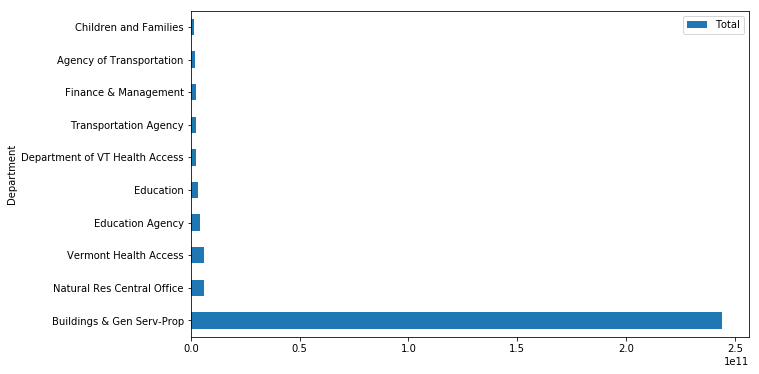

In [79]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
plot_df.plot(x = 'Department', y = 'Total', kind = 'barh', color = 'C0', ax = ax)

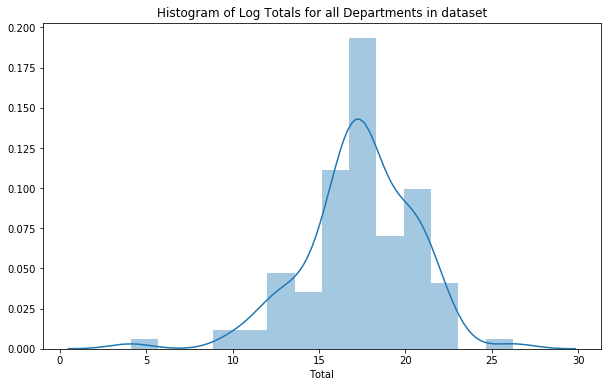

In [78]:
import numpy as np
import seaborn as sns
plot_df2 = spark.sql(
'''

SELECT Department, SUM(Amount) as Total FROM VermontVendor 
GROUP BY Department


'''
).toPandas()
plt.figure(figsize = (10,6))
sns.distplot(np.log(plot_df2['Total']))
plt.title('Histogram of Log Totals for all Departments in dataset')
plt.show()
